In [2]:
%pip install pandas numpy matplotlib seaborn scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 37.7 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 43.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [seaborn]m4/5 [seaborn]earn]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load the combined dataset
df = pd.read_csv('data/combined.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# Display basic info about the dataset
print(f"Dataset shape: {df.shape}")
print(f"\nDate range: {df.index.min()} to {df.index.max()}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (3046, 6)

Date range: 2016-01-01 00:00:00 to 2024-05-28 00:00:00

First few rows:


,pct,precip,precipcover,preciptype,snow,snowdepth
datetime,,,,,,
2016-01-01,0.687792,0.0,0.0,NaN,0.0,0.1
2016-01-02,0.739438,0.0,0.0,NaN,0.0,0.0
2016-01-03,0.740502,0.0,0.0,NaN,0.0,0.0
2016-01-04,0.730912,0.0,0.0,NaN,0.0,0.0
2016-01-05,0.721687,0.0,0.0,NaN,0.0,0.1


In [ ]:
print("Missing values:")
print(df.isnull().sum())
print("\n\nDataset statistics:")
df.describe()


Missing values:
pct               0
precip            0
precipcover       0
preciptype     1786
snow              0
snowdepth         0
dtype: int64


Dataset statistics:


,pct,precip,precipcover,snow,snowdepth
count,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000
mean,0.795950,0.119423,10.371602,0.047144,0.163920
std,0.048154,0.296103,18.425731,0.282535,0.561678
min,0.484794,0.000000,0.000000,0.000000,0.000000
25%,0.767951,0.000000,0.000000,0.000000,0.000000
50%,0.801900,0.000000,0.000000,0.000000,0.000000
75%,0.827895,0.072000,12.500000,0.000000,0.000000
max,0.977808,3.368000,100.000000,7.000000,5.400000


## 1. Time Series Analysis - Reliability Over Time


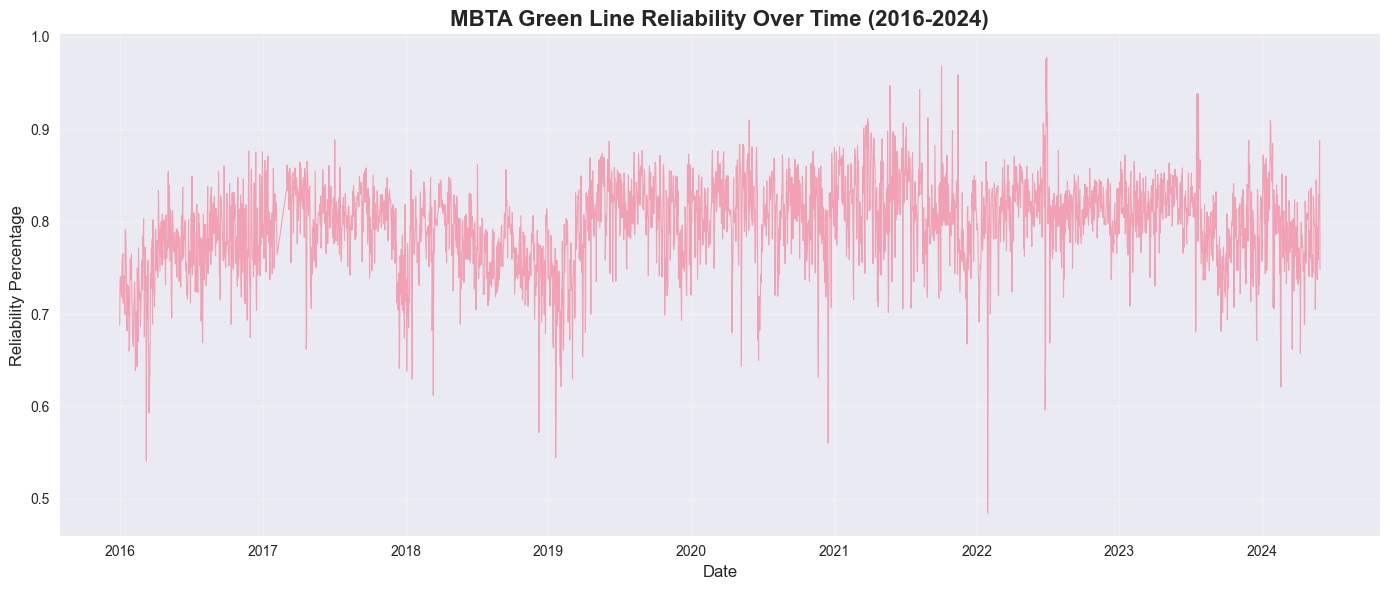

In [5]:
# Plot time series of reliability over the entire period
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['pct'], alpha=0.6, linewidth=0.8)
plt.title('MBTA Green Line Reliability Over Time (2016-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Reliability Percentage', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


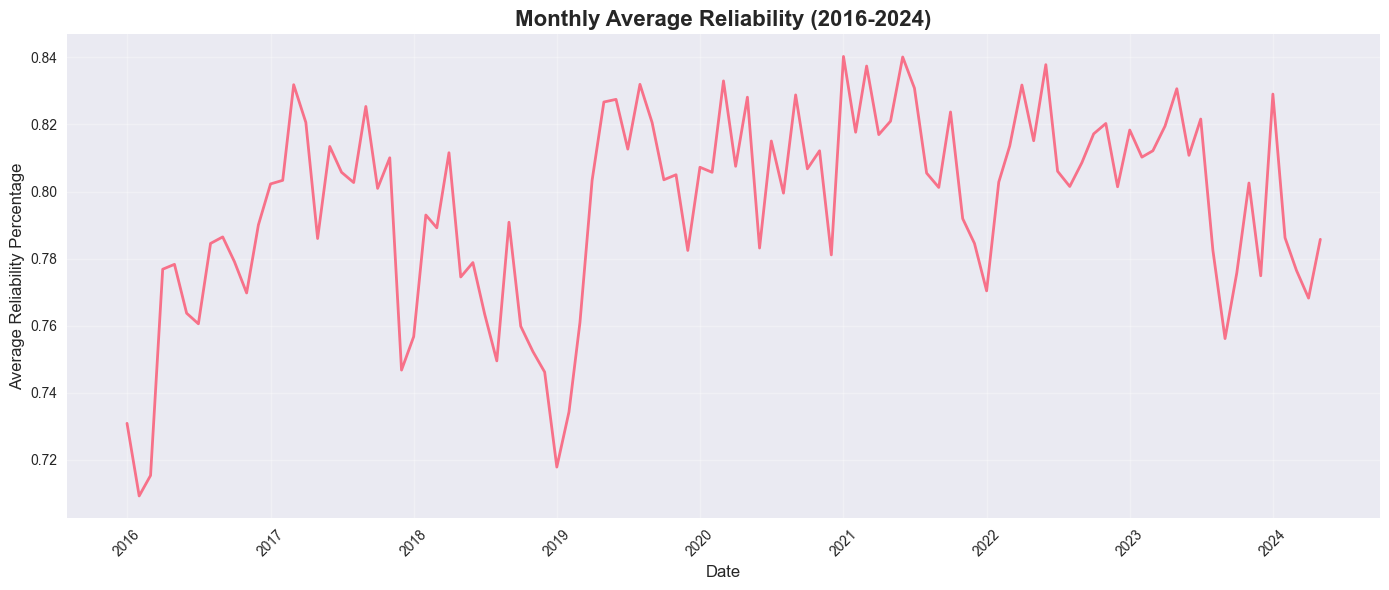

In [6]:
# Monthly average reliability
df['year_month'] = df.index.to_period('M')
monthly_avg = df.groupby('year_month')['pct'].mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_avg.index.to_timestamp(), monthly_avg.values, linewidth=2)
plt.title('Monthly Average Reliability (2016-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Reliability Percentage', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


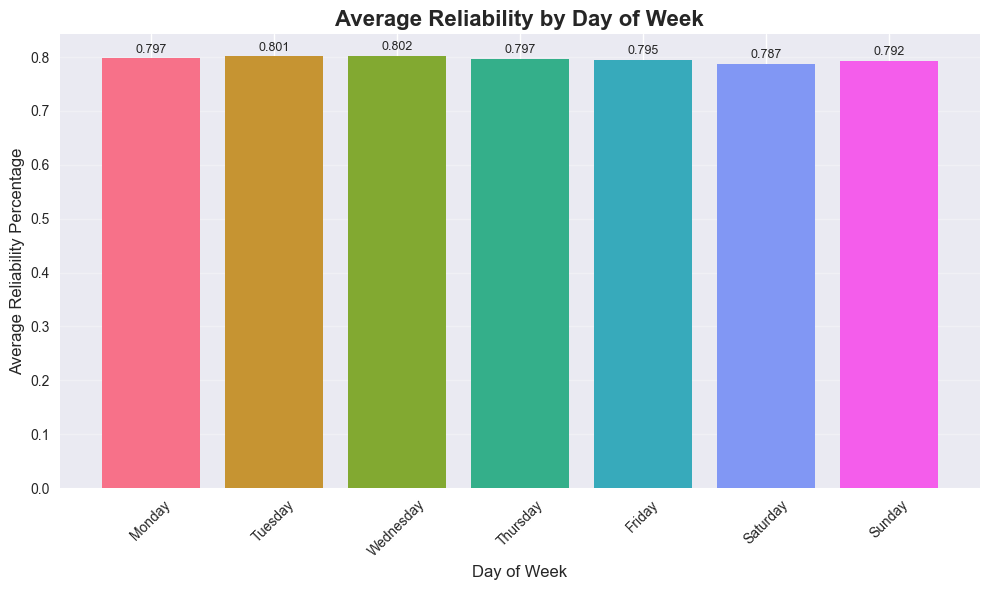

In [7]:
# Weekly pattern analysis
df['day_of_week'] = df.index.day_name()
df['hour'] = df.index.hour
df['month'] = df.index.month

# Average reliability by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_avg = df.groupby('day_of_week')['pct'].mean().reindex(day_order)

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(weekly_avg)), weekly_avg.values, color=sns.color_palette("husl", 7))
plt.title('Average Reliability by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Reliability Percentage', fontsize=12)
plt.xticks(range(len(weekly_avg)), weekly_avg.index, rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, weekly_avg.values)):
    plt.text(i, val + 0.005, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## 2. Transit Stress/Crowdedness Analysis

Treating low reliability as a proxy for crowdedness/transit stress, let's see how weather affects passenger experience.


## 2. Reliability vs Precipitation


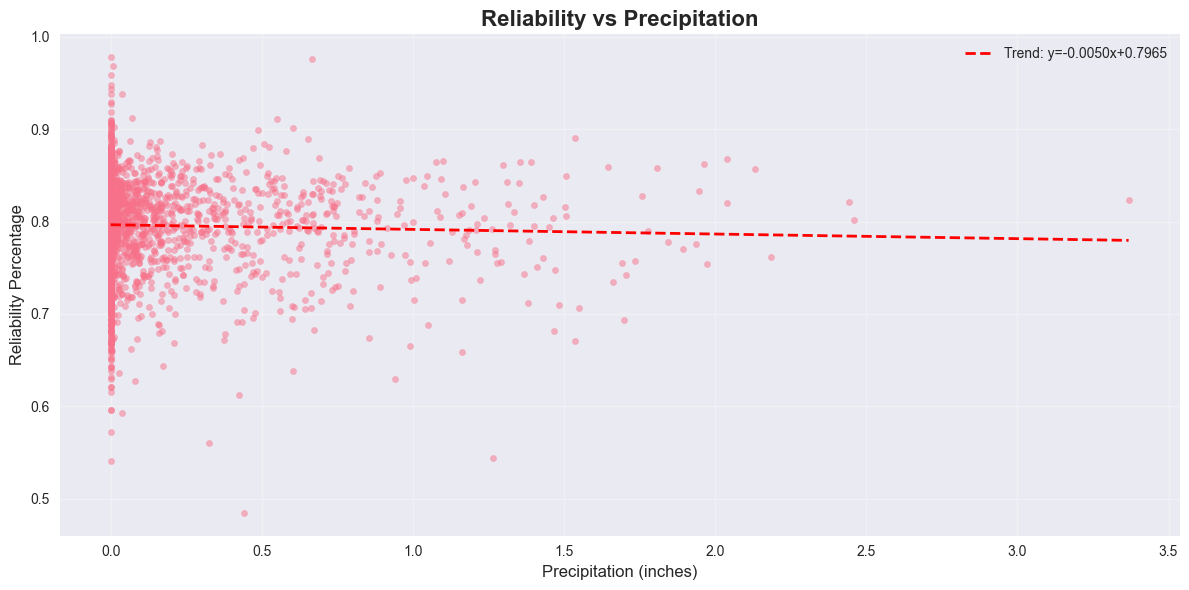

Correlation between reliability and precipitation: -0.0308


In [19]:
# Scatter plot: Reliability vs Precipitation
plt.figure(figsize=(12, 6))
plt.scatter(df['precip'], df['pct'], alpha=0.5, s=20)

# Add a trend line
z = np.polyfit(df['precip'], df['pct'], 1)
p = np.poly1d(z)
plt.plot(df['precip'].sort_values(), p(df['precip'].sort_values()), "r--", 
         linewidth=2, label=f'Trend: y={z[0]:.4f}x+{z[1]:.4f}')

plt.title('Reliability vs Precipitation', fontsize=16, fontweight='bold')
plt.xlabel('Precipitation (inches)', fontsize=12)
plt.ylabel('Reliability Percentage', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print correlation
correlation_precip = df['pct'].corr(df['precip'])
print(f"Correlation between reliability and precipitation: {correlation_precip:.4f}")


## 3. Reliability vs Snow


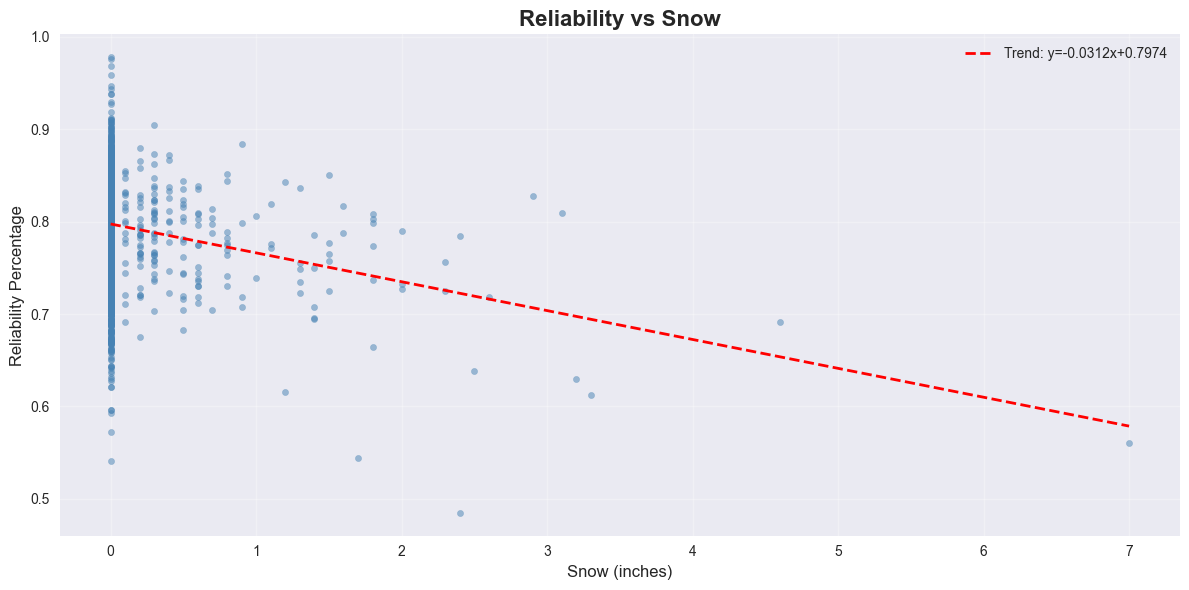

Correlation between reliability and snow: -0.1833


In [11]:
# Scatter plot: Reliability vs Snow
plt.figure(figsize=(12, 6))
plt.scatter(df['snow'], df['pct'], alpha=0.5, s=20, color='steelblue')

# Add a trend line
z = np.polyfit(df['snow'], df['pct'], 1)
p = np.poly1d(z)
plt.plot(df['snow'].sort_values(), p(df['snow'].sort_values()), "r--", 
         linewidth=2, label=f'Trend: y={z[0]:.4f}x+{z[1]:.4f}')

plt.title('Reliability vs Snow', fontsize=16, fontweight='bold')
plt.xlabel('Snow (inches)', fontsize=12)
plt.ylabel('Reliability Percentage', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print correlation
correlation_snow = df['pct'].corr(df['snow'])
print(f"Correlation between reliability and snow: {correlation_snow:.4f}")


## 4. Correlation Analysis - Weather and Reliability


In [13]:
# Detailed correlation values
print("Correlation between reliability and weather variables:")
print("=" * 60)
correlations = df[['pct', 'precip', 'precipcover', 'snow', 'snowdepth']].corr()['pct']
for var, corr in correlations.items():
    if var != 'pct':
        print(f"{var:15s}: {corr:8.4f}")


Correlation between reliability and weather variables:
precip         :  -0.0308
precipcover    :  -0.0513
snow           :  -0.1833
snowdepth      :  -0.1525


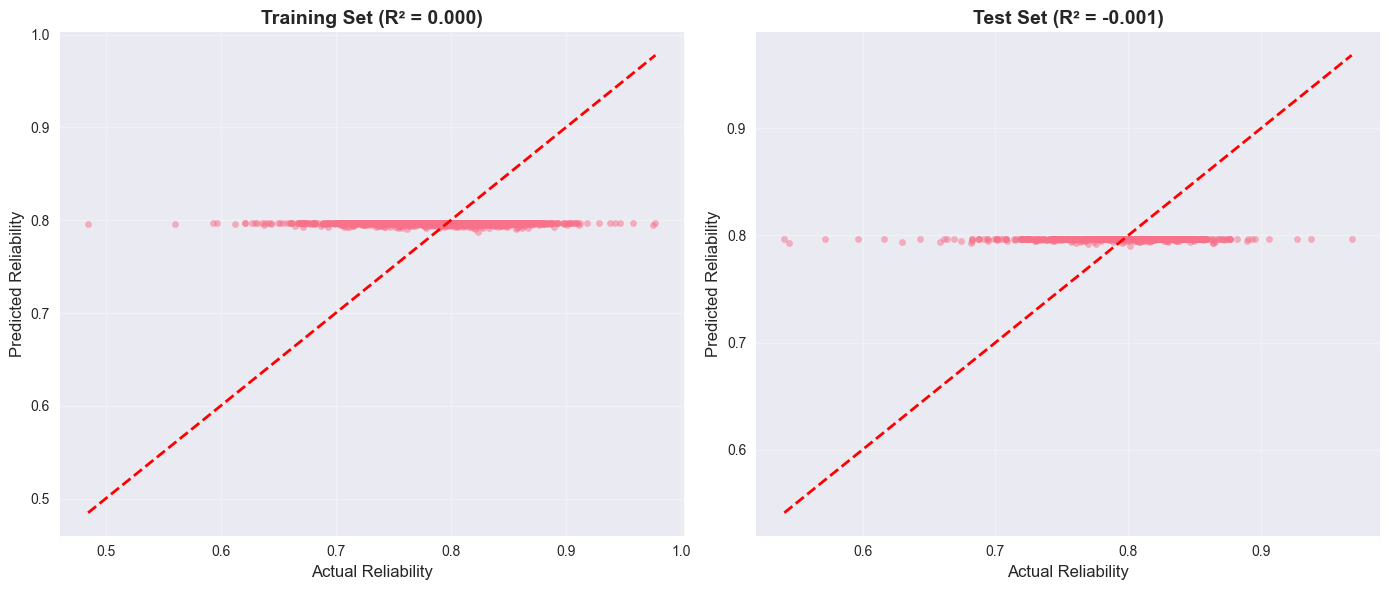

In [15]:
# Visualization: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training set
axes[0].scatter(y_train, y_pred_train, alpha=0.5, s=20)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Reliability', fontsize=12)
axes[0].set_ylabel('Predicted Reliability', fontsize=12)
axes[0].set_title(f'Training Set (R² = {train_r2:.3f})', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_pred_test, alpha=0.5, s=20)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Reliability', fontsize=12)
axes[1].set_ylabel('Predicted Reliability', fontsize=12)
axes[1].set_title(f'Test Set (R² = {test_r2:.3f})', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Multiple Variable Model


In [16]:
# Multiple variable model with all weather features
X_multi = model_df[['precip', 'precipcover', 'snow', 'snowdepth']].values

# Train/test split
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y, test_size=0.2, random_state=42)

# Train model
model_multi = LinearRegression()
model_multi.fit(X_train_multi, y_train_multi)

# Predictions
y_pred_train_multi = model_multi.predict(X_train_multi)
y_pred_test_multi = model_multi.predict(X_test_multi)

# Metrics
train_r2_multi = r2_score(y_train_multi, y_pred_train_multi)
test_r2_multi = r2_score(y_test_multi, y_pred_test_multi)
train_rmse_multi = np.sqrt(mean_squared_error(y_train_multi, y_pred_train_multi))
test_rmse_multi = np.sqrt(mean_squared_error(y_test_multi, y_pred_test_multi))

print("Multiple Variable Model (All weather features)")
print("=" * 50)
print(f"Train R² Score: {train_r2_multi:.4f}")
print(f"Test R² Score:  {test_r2_multi:.4f}")
print(f"Train RMSE:     {train_rmse_multi:.4f}")
print(f"Test RMSE:      {test_rmse_multi:.4f}")

print("\nModel coefficients:")
feature_names = ['precip', 'precipcover', 'snow', 'snowdepth']
for name, coef in zip(feature_names, model_multi.coef_):
    print(f"{name:15s}: {coef:8.4f}")
print(f"\nIntercept:       {model_multi.intercept_:.4f}")


Multiple Variable Model (All weather features)
Train R² Score: 0.0422
Test R² Score:  0.0368
Train RMSE:     0.0466
Test RMSE:      0.0491

Model coefficients:
precip         :   0.0021
precipcover    :  -0.0000
snow           :  -0.0244
snowdepth      :  -0.0078

Intercept:       0.7993


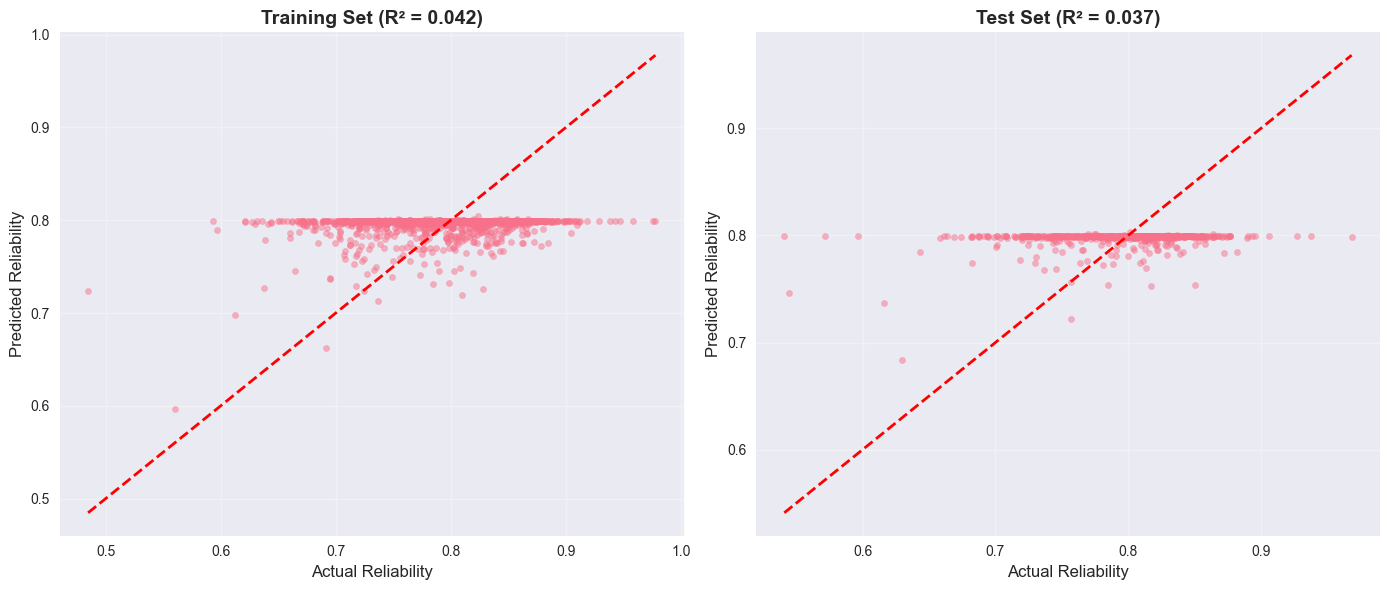

In [17]:
# Visualization: Actual vs Predicted (Multiple variables)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training set
axes[0].scatter(y_train_multi, y_pred_train_multi, alpha=0.5, s=20)
axes[0].plot([y_train_multi.min(), y_train_multi.max()], 
             [y_train_multi.min(), y_train_multi.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Reliability', fontsize=12)
axes[0].set_ylabel('Predicted Reliability', fontsize=12)
axes[0].set_title(f'Training Set (R² = {train_r2_multi:.3f})', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test_multi, y_pred_test_multi, alpha=0.5, s=20)
axes[1].plot([y_test_multi.min(), y_test_multi.max()], 
             [y_test_multi.min(), y_test_multi.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Reliability', fontsize=12)
axes[1].set_ylabel('Predicted Reliability', fontsize=12)
axes[1].set_title(f'Test Set (R² = {test_r2_multi:.3f})', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Clustering Analysis (Main Findings)


In [18]:
# Model comparison
comparison = pd.DataFrame({
    'Model': ['Precipitation Only', 'All Weather Variables'],
    'Train R²': [train_r2, train_r2_multi],
    'Test R²': [test_r2, test_r2_multi],
    'Train RMSE': [train_rmse, train_rmse_multi],
    'Test RMSE': [test_rmse, test_rmse_multi]
})

print("Model Comparison")
print("=" * 60)
print(comparison.to_string(index=False))

print("\n\nKey Insights:")
print("=" * 60)
print(f"1. Correlation with precipitation: {correlations['precip']:.4f}")
print(f"2. Correlation with snow: {correlations['snow']:.4f}")
print(f"3. Average reliability across all days: {df['pct'].mean():.4f}")
print(f"4. Reliability standard deviation: {df['pct'].std():.4f}")
print(f"5. Days with precipitation (precip > 0): {len(df[df['precip'] > 0])} ({len(df[df['precip'] > 0])/len(df)*100:.1f}%)")
print(f"6. Days with snow (snow > 0): {len(df[df['snow'] > 0])} ({len(df[df['snow'] > 0])/len(df)*100:.1f}%)")


Model Comparison
                Model  Train R²   Test R²  Train RMSE  Test RMSE
   Precipitation Only  0.000282 -0.001129    0.047641   0.050042
All Weather Variables  0.042203  0.036768    0.046632   0.049085


Key Insights:
1. Correlation with precipitation: -0.0308
2. Correlation with snow: -0.1833
3. Average reliability across all days: 0.7960
4. Reliability standard deviation: 0.0482
5. Days with precipitation (precip > 0): 1202 (39.5%)
6. Days with snow (snow > 0): 188 (6.2%)


## 7. K-Means Clustering Analysis

Let's cluster days into similar groups based on weather and reliability patterns to identify different "types of days" that might be useful for predicting transit hotspots.


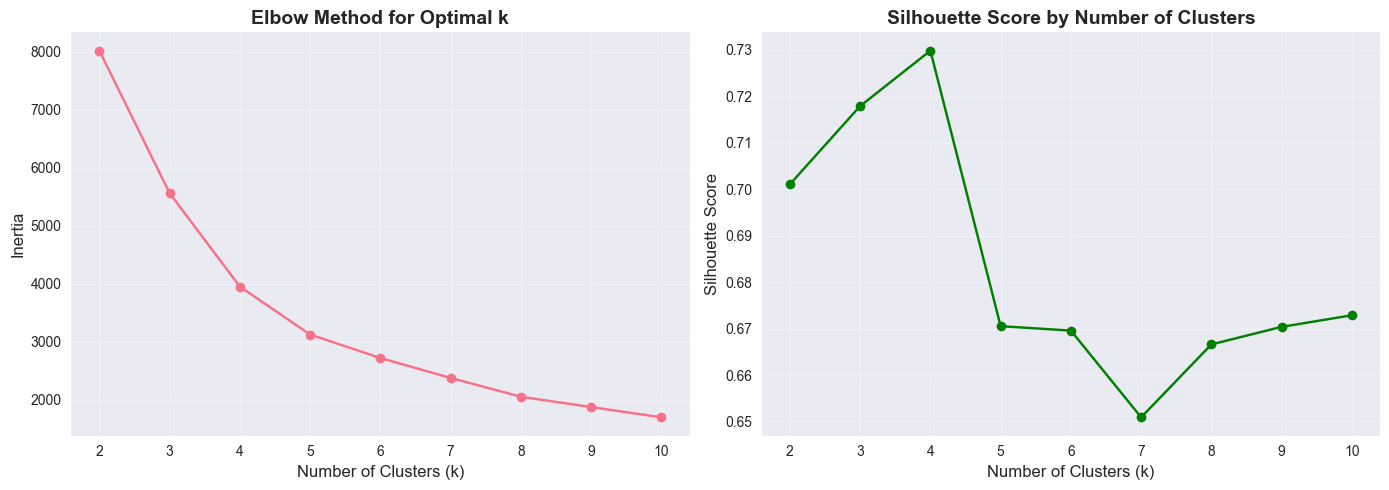

Silhouette scores by k:
k=2: 0.701
k=3: 0.718
k=4: 0.730
k=5: 0.671
k=6: 0.670
k=7: 0.651
k=8: 0.667
k=9: 0.670
k=10: 0.673


In [21]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Prepare data for clustering - use weather features
cluster_data = df[['precip', 'precipcover', 'snow', 'snowdepth']].copy()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_data)

# Determine optimal number of clusters using elbow method
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
axes[0].plot(K_range, inertias, marker='o')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette scores
axes[1].plot(K_range, silhouettes, marker='o', color='green')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score by Number of Clusters', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Silhouette scores by k:")
for k, score in zip(K_range, silhouettes):
    print(f"k={k}: {score:.3f}")


In [22]:
# Let's use k=4 clusters based on silhouette scores
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['weather_cluster'] = kmeans.fit_predict(X_scaled)

# Display cluster characteristics
print(f"\nCluster sizes (k={optimal_k}):")
print(df['weather_cluster'].value_counts().sort_index())

print("\n\nCluster centroids (weather characteristics):")
cluster_centers_df = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                                   columns=['precip', 'precipcover', 'snow', 'snowdepth'])
cluster_centers_df.index.name = 'Cluster'
print(cluster_centers_df.round(3))



Cluster sizes (k=4):
weather_cluster
0    2531
1     365
2      38
3     112
Name: count, dtype: int64


Cluster centroids (weather characteristics):
         precip  precipcover   snow  snowdepth
Cluster                                       
0         0.028        4.559  0.012      0.049
1         0.747       48.322  0.053      0.099
2         0.439       49.452  2.103      1.566
3         0.030        4.799  0.115      2.487



Reliability statistics by weather cluster:
                   mean     std  count
weather_cluster                       
0                0.7978  0.0461   2531
1                0.7947  0.0479    365
2                0.7324  0.0821     38
3                0.7805  0.0611    112


/var/folders/b_/5w5zl5zs4sg39hxy4rg4pmjh0000gn/T/ipykernel_51613/271537517.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[0].boxplot(cluster_data_for_plot, labels=[f'Cluster {i}' for i in cluster_order],


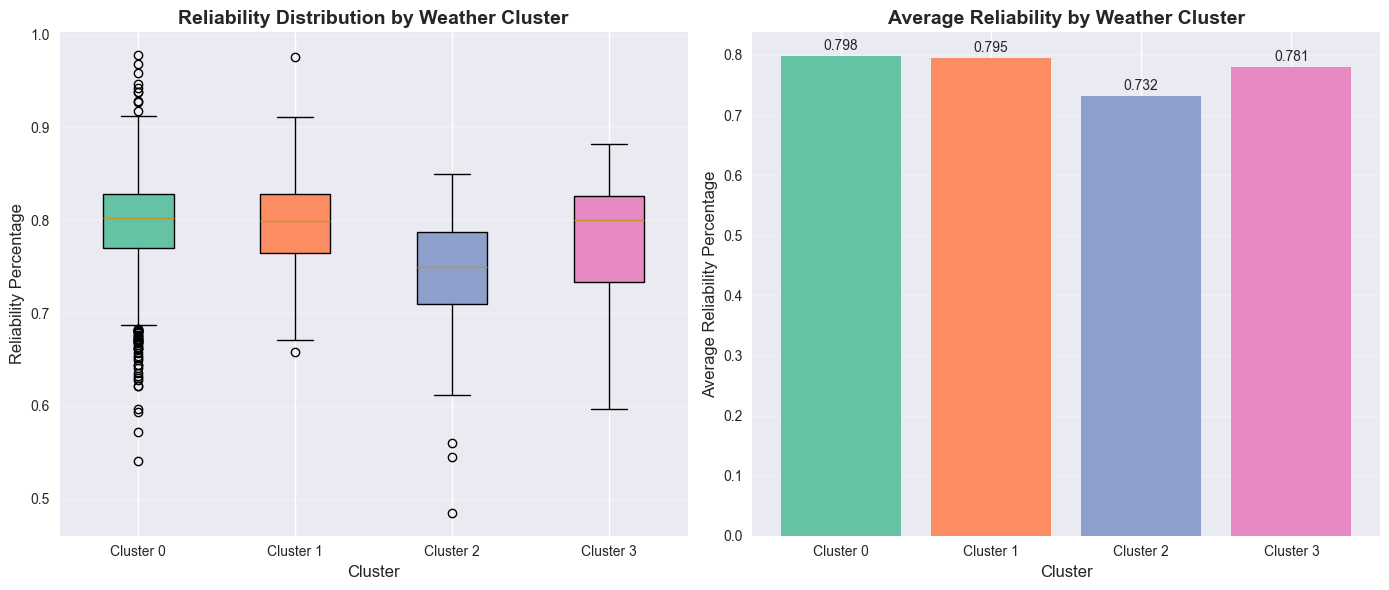

In [23]:
# Analyze reliability by cluster
cluster_reliability = df.groupby('weather_cluster')['pct'].agg(['mean', 'std', 'count'])

print("\nReliability statistics by weather cluster:")
print(cluster_reliability.round(4))

# Visualize clusters
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Reliability distribution by cluster
cluster_order = sorted(df['weather_cluster'].unique())
cluster_data_for_plot = [df[df['weather_cluster'] == c]['pct'].values for c in cluster_order]

box = axes[0].boxplot(cluster_data_for_plot, labels=[f'Cluster {i}' for i in cluster_order], 
                       patch_artist=True)
colors = sns.color_palette("Set2", len(cluster_order))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

axes[0].set_title('Reliability Distribution by Weather Cluster', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Reliability Percentage', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Average reliability by cluster
bars = axes[1].bar(range(len(cluster_reliability)), cluster_reliability['mean'].values, 
                     color=colors)
axes[1].set_title('Average Reliability by Weather Cluster', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Average Reliability Percentage', fontsize=12)
axes[1].set_xticks(range(len(cluster_reliability)))
axes[1].set_xticklabels([f'Cluster {i}' for i in cluster_reliability.index])
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, cluster_reliability['mean'].values)):
    axes[1].text(i, val + 0.005, f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


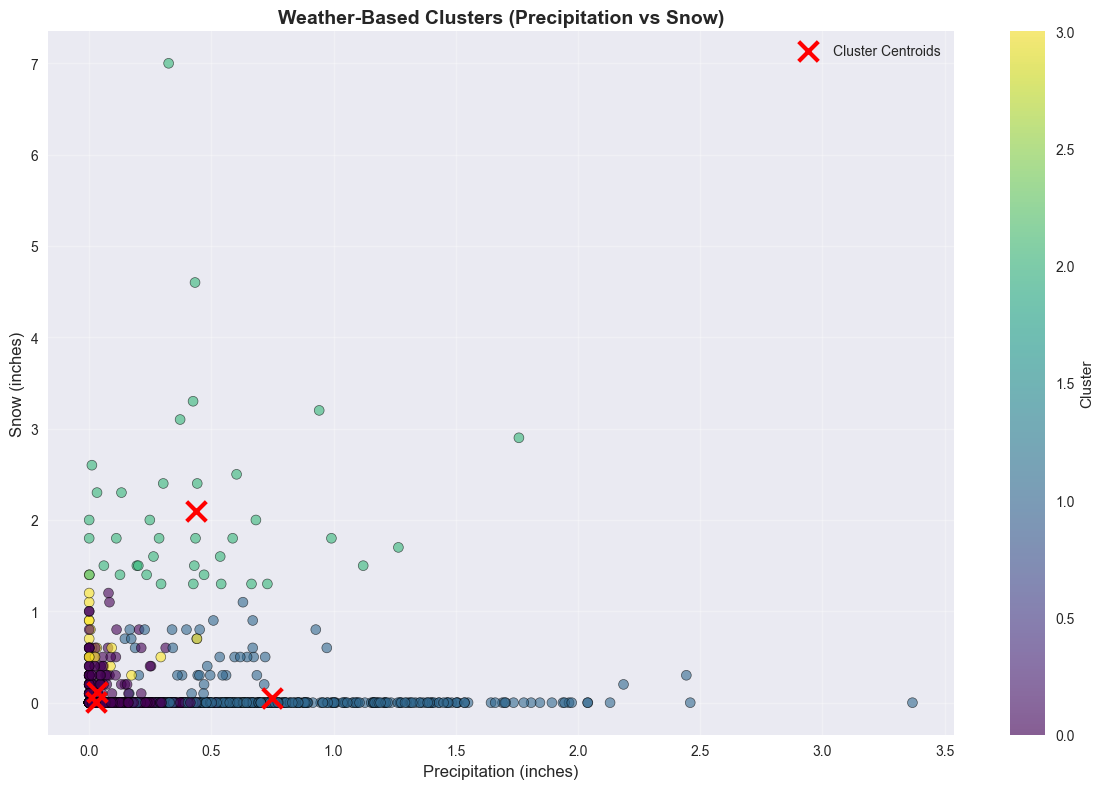

In [24]:
# Visualize clusters in 2D (precipitation vs snow)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['precip'], df['snow'], c=df['weather_cluster'], 
                       cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Precipitation (inches)', fontsize=12)
plt.ylabel('Snow (inches)', fontsize=12)
plt.title('Weather-Based Clusters (Precipitation vs Snow)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add cluster centroids
centroids_df = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                            columns=['precip', 'precipcover', 'snow', 'snowdepth'])
plt.scatter(centroids_df['precip'], centroids_df['snow'], 
            c='red', marker='x', s=200, linewidths=3, label='Cluster Centroids')
plt.legend()
plt.tight_layout()
plt.show()


### Cluster Analysis: Reliability-Based Clustering

Let's also cluster based on reliability patterns to find different "performance regimes"


In [25]:
# Cluster based on reliability (for anomaly detection)
reliability_range = df['pct'].max() - df['pct'].min()
print(f"Reliability range: {reliability_range:.3f}")

# Cluster reliability into performance groups
X_reliability = df[['pct']].values
scaler_rel = StandardScaler()
X_rel_scaled = scaler_rel.fit_transform(X_reliability)

# Use 3 clusters: low, medium, high reliability
kmeans_reliability = KMeans(n_clusters=3, random_state=42, n_init=10)
df['reliability_cluster'] = kmeans_reliability.fit_predict(X_rel_scaled)

# Get cluster centers to understand cutoffs
cluster_centers = scaler_rel.inverse_transform(kmeans_reliability.cluster_centers_)
cluster_labels = ['Low Reliability', 'Medium Reliability', 'High Reliability']
cluster_centers_sorted = sorted(zip(cluster_centers.flatten(), cluster_labels))

print("\nReliability clusters:")
for center, label in cluster_centers_sorted:
    count = len(df[df['reliability_cluster'] == list(cluster_centers.flatten()).index(center)])
    print(f"{label}: {center:.3f} ({count} days, {count/len(df)*100:.1f}%)")


Reliability range: 0.493

Reliability clusters:
High Reliability: 0.720 (538 days, 17.7%)
Medium Reliability: 0.789 (1383 days, 45.4%)
Low Reliability: 0.841 (1125 days, 36.9%)


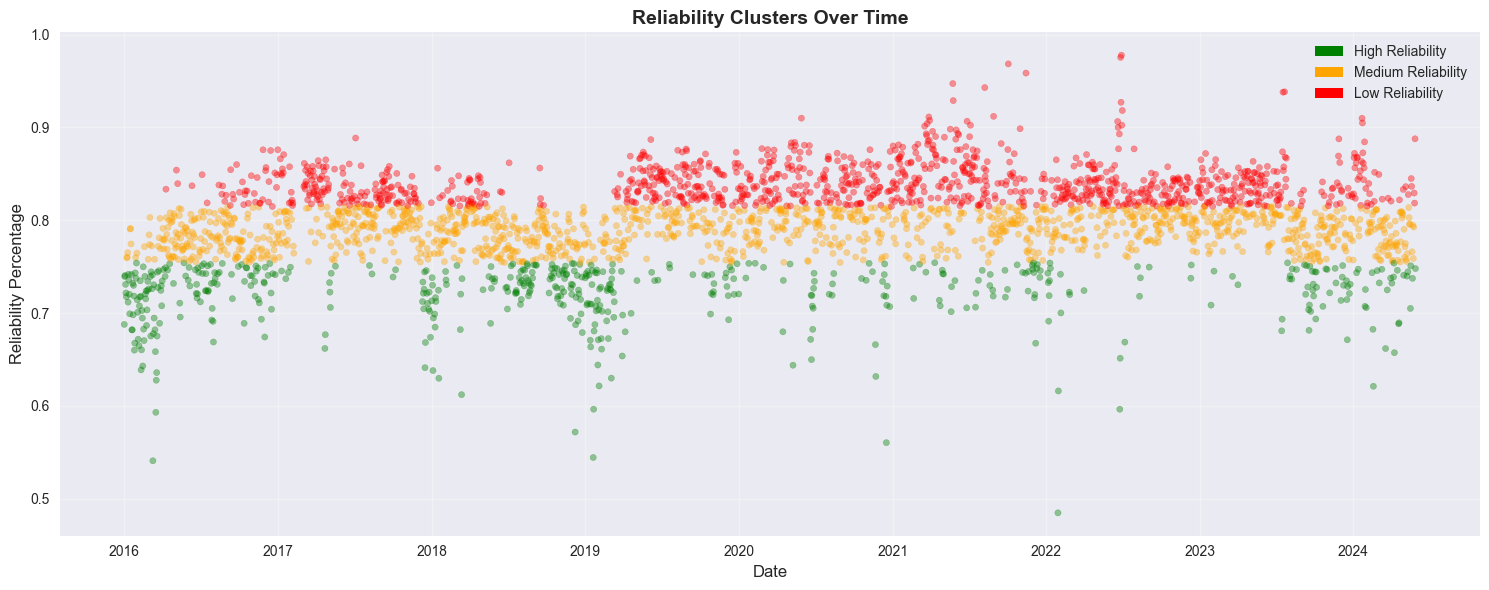

In [26]:
# Visualize reliability clusters over time
plt.figure(figsize=(15, 6))
colors_map = {0: 'red', 1: 'orange', 2: 'green'}
cluster_colors = df['reliability_cluster'].map(colors_map)

plt.scatter(df.index, df['pct'], c=cluster_colors, alpha=0.4, s=20)
plt.title('Reliability Clusters Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Reliability Percentage', fontsize=12)
plt.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', label='High Reliability'),
                   Patch(facecolor='orange', label='Medium Reliability'),
                   Patch(facecolor='red', label='Low Reliability')]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


In [27]:
# Analyze weather patterns by reliability cluster
reliability_weather = df.groupby('reliability_cluster')[['precip', 'precipcover', 'snow', 'snowdepth']].agg(['mean', 'std'])

print("\nWeather patterns by reliability cluster:")
print("=" * 70)
for cluster_idx in sorted(df['reliability_cluster'].unique()):
    cluster_name = ['Low', 'Medium', 'High'][cluster_idx]
    print(f"\n{cluster_name} Reliability Cluster ({cluster_idx}):")
    cluster_stats = reliability_weather.loc[cluster_idx]
    
    for weather_var in ['precip', 'precipcover', 'snow', 'snowdepth']:
        mean_val = cluster_stats[(weather_var, 'mean')]
        std_val = cluster_stats[(weather_var, 'std')]
        print(f"  {weather_var:15s}: {mean_val:6.3f} ± {std_val:6.3f}")



Weather patterns by reliability cluster:

Low Reliability Cluster (0):
  precip         :  0.119 ±  0.306
  precipcover    : 10.063 ± 17.795
  snow           :  0.020 ±  0.144
  snowdepth      :  0.128 ±  0.484

Medium Reliability Cluster (1):
  precip         :  0.114 ±  0.282
  precipcover    : 10.283 ± 18.244
  snow           :  0.039 ±  0.217
  snowdepth      :  0.126 ±  0.469

High Reliability Cluster (2):
  precip         :  0.133 ±  0.311
  precipcover    : 11.245 ± 20.120
  snow           :  0.123 ±  0.530
  snowdepth      :  0.336 ±  0.835


### Insights from Clustering


In [28]:
# Cross-tabulation: weather clusters vs reliability clusters
crosstab = pd.crosstab(df['weather_cluster'], df['reliability_cluster'], 
                        margins=True, margins_name='Total')

print("\nWeather Clusters vs Reliability Clusters:")
print("=" * 70)
print(crosstab)
print(f"\nTotal days: {len(df)}")

# Calculate probabilities
print("\n\nProbability of reliability level given weather cluster:")
for weather_cluster in sorted(df['weather_cluster'].unique())[:-1]:
    weather_data = df[df['weather_cluster'] == weather_cluster]
    for rel_cluster in [0, 1, 2]:
        count = len(weather_data[weather_data['reliability_cluster'] == rel_cluster])
        prob = count / len(weather_data) * 100
        cluster_name = ['Low', 'Medium', 'High'][rel_cluster]
        print(f"Weather Cluster {weather_cluster} -> {cluster_name} Reliability: {prob:.1f}%")



Weather Clusters vs Reliability Clusters:
reliability_cluster     0     1    2  Total
weather_cluster                            
0                     949  1168  414   2531
1                     133   163   69    365
2                       4    14   20     38
3                      39    38   35    112
Total                1125  1383  538   3046

Total days: 3046


Probability of reliability level given weather cluster:
Weather Cluster 0 -> Low Reliability: 37.5%
Weather Cluster 0 -> Medium Reliability: 46.1%
Weather Cluster 0 -> High Reliability: 16.4%
Weather Cluster 1 -> Low Reliability: 36.4%
Weather Cluster 1 -> Medium Reliability: 44.7%
Weather Cluster 1 -> High Reliability: 18.9%
Weather Cluster 2 -> Low Reliability: 10.5%
Weather Cluster 2 -> Medium Reliability: 36.8%
Weather Cluster 2 -> High Reliability: 52.6%
